In [2]:
# Standard library imports
from collections import deque, namedtuple, OrderedDict
import random
import time
from typing import Iterator, List, NamedTuple, Optional, Tuple

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageGrab
from pynput.keyboard import Key, Controller
from pytesseract import image_to_string
import pytorch_lightning as pl
import torch
from torch import nn
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, IterableDataset
from torchvision import transforms

# Environment
I tried to make this resemble OpenAI Gym's environment class `gym.Env`, just based on their ["Getting Started" page](https://gym.openai.com/docs/#environments).

In [120]:
GAME_WINDOW_BBOX    = (490,130,1485,575) # Tuned for my own display, crops out the floor
GAME_OVER_TEXT_BBOX = (850,350,1125,400) # Tuned for my own display
STAY_ALIVE_REWARD   = 0.1                # The longer the episode, the better
JUMP_REWARD         = -1                 # Minor penalty, to discourage from constant jumping
TARGET_IMAGE_SIZE   = (84,84)            # The width and height of the screen after re-sizing
IMAGE_STACK_DEPTH   = 4                  # The number of images to stack for model input
        

class PenguinRunEnvironment:    
    """
    Provides an interface for interacting with the Penguin Run game.
    
    ----------
    Parameters
    ----------
    game_window_bbox: A 4-tuple of the form (x1,y1,x2,y2), where (x1,y1) is the
        coordinate of the upper-left bound and (x2,y2) is the coordinate of the
        lower-left bound of the game window.
    game_over_text_bbox: A 4-tuple of the form (x1,y1,x2,y2), where (x1,y1) is
        the coordinate of the upper-left bound and (x2,y2) is the coordinate of
        the lower-left bound of where the text "GAME OVER" appears in the game
        window.
    """
    def __init__(self, 
                 game_window_bbox: Tuple[int,int,int,int],
                 game_over_text_bbox: Tuple[int,int,int,int]) -> None:
        self.game_window_bbox = game_window_bbox
        self.game_over_text_bbox = game_over_text_bbox
        self.keyboard = Controller()
        self.action_space = [0, 1] # [NO JUMP, JUMP]
        self.n_actions = len(self.action_space)
        self.stack_depth = IMAGE_STACK_DEPTH
        self.target_image_size = TARGET_IMAGE_SIZE
        self.frame_stack = self._create_clean_image_deque()
        
    def reset(self) -> np.ndarray:
        """
        Presses the space bar to restart the game. (Assumes the game window is 
        currently in focus and is in the "GAME OVER" state.
        
        ----------
        Returns
        ----------
        A screenshot of the game window.
        """
        time.sleep(2) # Give a short delay so we can switch windows, if needed
        self.frame_stack = self._create_clean_image_deque()
        self.keyboard.press(Key.space)
        self.keyboard.release(Key.space)
        obs = self._observe(is_new_episode=True)
        return obs
    
    def step(self, action: int) -> (np.ndarray, float, bool): 
        """
        Performs the given action in the environment.
        
        ----------
        Parameters
        ----------
        action: The action to perform (0 or 1).
        
        ----------
        Returns
        ----------
        A 3-tuple where the first element is a screenshot of the
        game, the second element is the reward achieved by the
        given action, and the third element is a boolean indicating
        whether the environment should be reset.
        """
        assert action in self.action_space
        reward = 0
        
        if action == 0:
            self.keyboard.press(Key.space)
            self.keyboard.release(Key.space)
            reward += JUMP_REWARD
        elif action == 1:
            pass
        
        obs = self._observe()
        needs_reset = self._is_game_over()
        reward += STAY_ALIVE_REWARD if not needs_reset else 0
        return (obs, reward, needs_reset)
        
    def sample_action(self) -> int:
        """        
        Gets an action randomly chosen from the action space.
        """
        return random.choice(self.action_space)

    def _observe(self, is_new_episode: Optional[bool] = False) -> np.ndarray:
        """        
        ----------
        Parameters
        ----------
        is_new_episode: If the environment was just reset.

        ----------
        Returns
        ----------
        A observation containing a screenshot and a deque of times
        since previous jumps.
        """
        pil_img = (ImageGrab.grab(bbox=self.game_window_bbox)
                   .convert('L')
                   .resize(self.target_image_size))
        screen = np.array(pil_img) / 255.0
        obs = self._stack_frames(screen, is_new_episode)
        return obs
    
    def _is_game_over(self) -> bool:
        """     
        ----------
        Returns
        ----------
        True, if the screen says "GAME OVER". False, otherwise.
        """
        pil_img = ImageGrab.grab(bbox=self.game_over_text_bbox)
        screen = np.array(pil_img)
        try:
            txt = image_to_string(screen, timeout=0.1).strip()
            game_over = (txt == 'GAME OVER')
        except:
            game_over = False
        return game_over
    
    def _create_clean_image_deque(self) -> deque:
        """      
        ----------
        Returns
        ----------
        A clean image deque.
        """
        return deque([np.zeros(self.target_image_size, dtype=np.float32) \
                      for i in range(self.stack_depth)], maxlen=4)
    
    def _stack_frames(self, frame: np.ndarray, is_new_episode: bool) -> np.ndarray:
        """
        ----------
        Parameters
        ----------
        frame: A NumPy array representing the frame to add to the stack.
        is_new_episode: If the environment was just reset.
        
        ----------
        Returns
        ----------
        The stacked frames.
        """
        if is_new_episode:
            for i in range(self.frame_stack.maxlen):
                self.frame_stack.append(frame)
        else:
            self.frame_stack.append(frame)
        stacked_frame = np.stack(self.frame_stack, axis=2).T
        return stacked_frame

In [25]:
# Test environment interaction
env = PenguinRunEnvironment(GAME_WINDOW_BBOX, GAME_OVER_TEXT_BBOX)
episodes = 3
for i in range(episodes):
    print('*' * 10)
    print(f'EPISODE {i}')
    env.reset()
    time.sleep(1)
    done = False
    cumulative_reward = 0
    while not done:
        action = env.sample_action()
        obs, reward, done = env.step(action)
        cumulative_reward += reward
        time.sleep(0.1)
    print(f'Result: {cumulative_reward}')

**********
EPISODE 0
Result: -75
**********
EPISODE 1
Result: -126
**********
EPISODE 2
Result: -8


# Deep Q-Network
Based on the [PyTorch Lightning tutorial](https://pytorch-lightning.readthedocs.io/en/latest/notebooks/lightning_examples/reinforce-learning-DQN.html).

In [104]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            # ~> (4,84,84)
            nn.Conv2d(in_channels=IMAGE_STACK_DEPTH,
                      out_channels=32,
                      kernel_size=(8,8),
                      stride=(4,4)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # ~> (32,20,20)
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=(4,4),
                      stride=(2,2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # ~> (64,9,9)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(4,4),
                      stride=(2,2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # ~> (3,3,128)
            nn.Flatten(),
            # ~> (1152)
            nn.Linear(in_features=1152,
                      out_features=512),
            nn.ReLU(),
            # ~> (512)
            nn.Linear(in_features=512,
                      out_features=2)
            # ~> (2)
        )
        
    def forward(self, x):
        return self.net(x)   

In [105]:
# Test DQN
def create_img_stack():
    img_stack = []
    for i in range(4):
        pil_img = ImageGrab.grab(bbox=GAME_WINDOW_BBOX).convert('L').resize(TARGET_IMAGE_SIZE)
        np_arr = np.array(pil_img) / 255.0
        img_stack.append(np_arr)
        time.sleep(0.02)
    img_stack = torch.Tensor(np.array(img_stack))
    return img_stack

x = create_img_stack()
print(x.shape)
print(x.dtype)
dqn = DQN()
dqn.forward(x.unsqueeze(0))

torch.Size([4, 84, 84])
torch.float32


tensor([[-0.0754,  0.1045]], grad_fn=<AddmmBackward>)

# Memory

In [124]:
# Named tuple for storing experience steps gathered in training
Experience = namedtuple(
    'Experience',
    field_names=['state', 'action', 'reward', 'done', 'new_state'],
)

class ReplayBuffer:
    """
    Replay Buffer for storing past experiences allowing the agent to learn from them.

    ----------
    Parameters
    ----------
    capacity: Size of the buffer.
    """

    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(self, experience: Experience) -> None:
        """
        Adds the given experience to the buffer.
        
        ----------
        Parameters
        ----------
        experience: A tuple of the form (state, action, reward, done, new_state).
        """
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*(self.buffer[idx] for idx in indices))

        return (
            np.array(states, dtype=np.float32),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=bool),
            np.array(next_states, dtype=np.float32),
        )
    
class RLDataset(IterableDataset):
    """
    Iterable Dataset containing the ExperienceBuffer which will be updated with
    new experiences during training.

    ----------
    Parameters
    ----------
    buffer: Replay buffer.
    sample_size: Number of experiences to sample at a time.
    """

    def __init__(self, buffer: ReplayBuffer, sample_size: Optional[int] = 200) -> None:
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self) -> Iterator:
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

# Agent

In [114]:
class Agent:
    """
    Handles interaction with the environment.
    """
    def __init__(self, env: PenguinRunEnvironment, replay_buffer: ReplayBuffer) -> None:
        self.env = env
        self.replay_buffer = replay_buffer
        time.sleep(2) # Time to switch windows
        self.reset()
    
    def reset(self) -> None:
        self.state = self.env.reset()
        
    def get_action(self, net: nn.Module, epsilon: float, device: str) -> int:
        if np.random.random() < epsilon:
            action = self.env.sample_action()
        else:
            state = torch.FloatTensor([self.state])
            
            if device != 'cpu':
                state = state.cuda(device)
            
            q_values = net(state)
            _, action = torch.max(q_values, dim=1)
            action = int(action.item())
        
        return action
    
    @torch.no_grad()
    def play_step(
        self,
        net: nn.Module,
        epsilon: float = 0.0,
        device: str = 'cpu'
    ) -> Tuple[float, bool]:
        action = self.get_action(net, epsilon, device)
        new_state, reward, done = self.env.step(action)
        exp = Experience(self.state, action, reward, done, new_state)
        self.replay_buffer.append(exp)
        self.state = new_state
        if done:
            self.reset()
        return reward, done

In [111]:
# Test Agent
agent = Agent(PenguinRunEnvironment(GAME_WINDOW_BBOX, GAME_OVER_TEXT_BBOX), ReplayBuffer(1000))
action = agent.get_action(DQN(), epsilon=0, device='cpu')
print(action)

1


# DQN Lightning Module

In [122]:
class DQNLightning(pl.LightningModule):
    def __init__(
        self,
        batch_size: int = 16,
        lr: float = 1e-4,
        gamma: float = 0.99,
        sync_rate: int = 10,
        replay_size: int = 1000,
        warm_start_size: int = 1000,
        eps_last_frame: int = 1000,
        eps_start: float = 1.0,
        eps_end: float = 0.01,
        episode_length: int = 200,
        warm_start_steps: int = 1000
    ) -> None:
        """
        ----------
        Parameters
        ----------
        batch_size: Size of the batches.
        lr: Learning rate.
        gamma: Discount factor.
        sync_rate: How many frames do we update the target network.
        replay_size: Capacity of the replay buffer.
        warm_start_size: How many samples do we use to fill our buffer
            at the start of training.
        eps_last_frame: What frame should epsilon stop decaying.
        eps_start: Epsilon starting value.
        eps_end: Epsilon final value.
        episode_length: Max length of an episode.
        warm_start_steps: Max episode reward in the environment.
        """
        super().__init__()
        self.save_hyperparameters()

        self.env = PenguinRunEnvironment(GAME_WINDOW_BBOX, GAME_OVER_TEXT_BBOX)

        self.net = DQN()
        self.target_net = DQN()

        self.buffer = ReplayBuffer(self.hparams.replay_size)
        self.agent = Agent(self.env, self.buffer)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.hparams.warm_start_steps)
    
    def populate(self, steps: int = 1000) -> None:
        """
        Carries out several random steps through the environment to initially fill
        up the replay buffer with experiences

        ----------
        Parameters
        ----------
        steps: Number of random steps to populate the buffer with.
        """
        time.sleep(2) # Gives time to change windows
        for i in range(steps):
            self.agent.play_step(self.net, epsilon=1.0)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.net(x)
        return output
    
    def dqn_mse_loss(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        states, actions, rewards, dones, next_states = batch
        state_action_values = self.net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        with torch.no_grad():
            next_state_values = self.target_net(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()
        
        expected_state_action_values = next_state_values * self.hparams.gamma + rewards
        
        return nn.MSELoss()(state_action_values, expected_state_action_values)
    
    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], nb_batch) -> OrderedDict:
        device = self.get_device(batch)
        epsilon = max(
            self.hparams.eps_end,
            self.hparams.eps_start - self.global_step + 1 / self.hparams.eps_last_frame,
        )

        # step through environment with agent
        reward, done = self.agent.play_step(self.net, epsilon, device)
        self.episode_reward += reward

        # calculates training loss
        loss = self.dqn_mse_loss(batch)

        if done:
            self.total_reward = self.episode_reward
            self.episode_reward = 0

        # Soft update of target network
        if self.global_step % self.hparams.sync_rate == 0:
            self.target_net.load_state_dict(self.net.state_dict())

        log = {
            'total_reward': torch.tensor(self.total_reward).to(device),
            'reward': torch.tensor(reward).to(device),
            'train_loss': loss
        }
        status = {
            'steps': torch.tensor(self.global_step).to(device),
            'total_reward': torch.tensor(self.total_reward).to(device)
        }
        return loss

    def configure_optimizers(self) -> List[Optimizer]:
        """ Initialize Adam optimizer"""
        optimizer = Adam(self.net.parameters(), lr=self.hparams.lr)
        return [optimizer]

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences"""
        dataset = RLDataset(self.buffer, self.hparams.episode_length)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.hparams.batch_size,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader"""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch"""
        return batch[0].device.index if self.on_gpu else 'cpu'

# Run the model

In [125]:
model = DQNLightning()

AVAIL_GPUS = min(1, torch.cuda.device_count())
trainer = pl.Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=200,
    val_check_interval=100,
)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params
------------------------------------
0 | net        | DQN  | 764 K 
1 | target_net | DQN  | 764 K 
------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.113     Total estimated model params size (MB)
/home/school/anaconda3/envs/deep-rl/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

/home/school/anaconda3/envs/deep-rl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [142]:
states, actions, rewards, dones, next_states = model.agent.replay_buffer.sample(1)

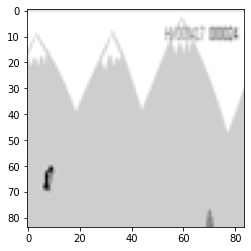

In [147]:
plt.imshow(np.array(states[0,3,:,:].T), cmap='gray')

In [145]:
rewards

array([0.1], dtype=float32)